In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
# add_messages act as reducer for the graph, it will add messages to the graph and return the new graph
# it will also return the messages that were added to the graph

# mesaags=[__,__,__] where message is a state 




In [ ]:
class State(TypedDict):
    """ State of the graph, it will be a dictionary with the following keys"""
    messages:Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [14]:
from dotenv import load_dotenv
load_dotenv()
# No API key needed for local Ollama

True

In [15]:
from langchain_ollama import ChatOllama

In [16]:
llm = ChatOllama(model="mistral", base_url="http://localhost:11434")

In [17]:
def Chatbot(state:State):
    return {"messages": [llm.invoke(state["messages"])]}


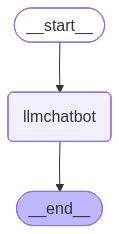

In [18]:
graph_builder.add_node("llmchatbot",Chatbot)
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)
graph=graph_builder.compile()
from IPython.display import Image ,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Graph visualization failed:", e)    

In [19]:
response=graph.invoke({"messages": ["Hello, how are you doing?"]})

ResponseError: model 'mistral' not found (status code: 404)

In [ ]:
response["messages"][-1].content

"I'm just a language model, I don't have emotions or feelings like humans do. However, I'm functioning properly and ready to assist you with any questions or tasks you may have! It's great to chat with you. How can I help you today?"

In [ ]:
for event in graph.stream({"messages": ["Hello, how are you doing?"]}):
    for values in event.values():
        print(values["messages"][-1].content)

I'm just an AI, so I don't have feelings or emotions like humans do. I'm simply a computer program designed to understand and respond to natural language inputs!


### chatbot with tools using langgraph

In [ ]:

import os

from dotenv import load_dotenv
load_dotenv()
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=3, tavily_api_key=TAVILY_API_KEY)
tool.invoke("What is the capital of France?")

{'query': 'What is the capital of France?',
 'response_time': 1.21,
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://en.wikipedia.org/wiki/List_of_capitals_of_France',
   'title': 'List of capitals of France - Wikipedia',
   'content': 'The capital of France has been Paris since its liberation in 1944.',
   'score': 0.9108078,
   'raw_content': None},
  {'url': 'https://home.adelphi.edu/~ca19535/page%204.html',
   'title': 'Paris facts: the capital of France in history',
   'content': 'Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011.',
   'score': 0.8795718,
   'raw_content': None},
  {'url': 'https://www.facebook.com/61551442420211/posts/paris-the-capital-and-largest-city-of-france-is-located-in-the-northern-part-of-/122180773544048080/',
   'title': 'Paris , the capital and largest city of France, is located in ... - Facebook',
   'content'

In [ ]:
def multiply(x,y):
    """ Multiplies two numbers together. 
        Args:
            x: The first number.    
            y: The second number.
        Returns:
            The product of x and y.    
    """
    return x*y

In [ ]:
tools=[tool,multiply]


In [ ]:
llm_with_tools=llm.bind_tools(tools)

In [ ]:
## State graph with tools

from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list, add_messages]

#graph 
graph_builder = StateGraph(State)


# tool node
graph_builder.add_node("tools",ToolNode(tools))

In [ ]:
## create llm chatbot node
def Chatbot(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("llmchatbot_caling_tool",Chatbot)
graph_builder.add_edge(START,"llmchatbot_caling_tool")
graph_builder.add_conditional_edges("llmchatbot_caling_tool", tools_condition)
graph_builder.add_edge("tools",END)

graph=graph_builder.compile()
try:
    display(Image(graph.get_graph().draw_mermaid_png()))

except Exception as e:
    print("Graph visualization failed:", e)

Graph visualization failed: name 'Image' is not defined


In [ ]:
graph.invoke({"messages": ["What is the current ai news"]})

ResponseError: model 'mistral' not found (status code: 404)